In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
import os
sys.path.append("../../")

import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.style.use('ggplot')

import tensorflow as tf
tf.get_logger().setLevel('INFO')
import tensorflow_probability as tfp

from transport_nets.bijectors import BananaMap, BananaFlow
from transport_nets.models import NVP

tfd = tfp.distributions
tfb = tfp.bijectors

## Training the Model

First, we set up the normalizing flow so that it will save once every 5 epochs. In the next sections we will show how to load the saved model.

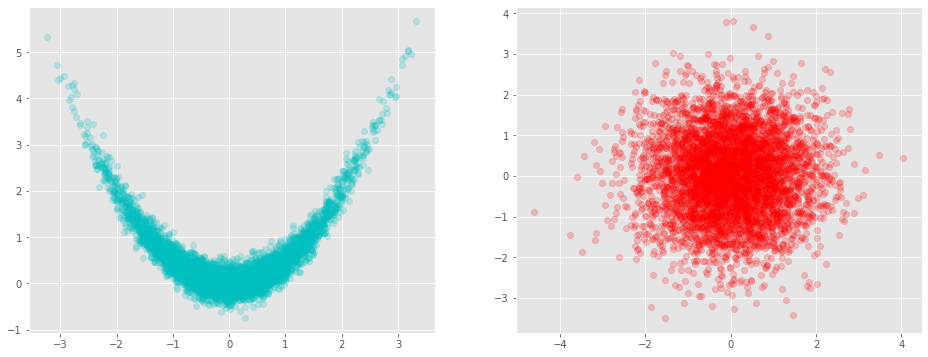

In [2]:
# Draw samples from both the target and the reference/latent space
num_samples = 5000
bMap = BananaMap((1.0,0.5,0.2,0.0))
bFlow = BananaFlow(bMap)
target = bFlow.sample(num_samples)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2);

In [3]:
# Create model object and optimizer
nvp = NVP(output_dim=2,num_layers=4,num_masked=1,neuron_list=[100,100])
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-06)
nvp.compile(opt)

In [4]:
# Setup checkpoints
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

In [5]:
# Define training options
n_epochs = 50
batch_size = 100

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
nvp.fit(dataset, epochs=n_epochs,callbacks=[cp_callback] )  # Pass callback to training
# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)
model_file = 'nvp_model.h5py'
nvp.save_model(model_file)

Epoch 1/50
50/50 [==============================] - 1s 18ms/step - Negative Log Likelihood: 2.1573
Epoch 2/50
50/50 [==============================] - 1s 17ms/step - Negative Log Likelihood: 1.8007
Epoch 3/50
50/50 [==============================] - 1s 17ms/step - Negative Log Likelihood: 1.5994
Epoch 4/50
50/50 [==============================] - 1s 18ms/step - Negative Log Likelihood: 1.4571
Epoch 5/50
49/50 [============================>.] - ETA: 0s - Negative Log Likelihood: 1.3995
Epoch 00005: saving model to training/cp.ckpt
50/50 [==============================] - 1s 19ms/step - Negative Log Likelihood: 1.3949
Epoch 6/50
50/50 [==============================] - 1s 18ms/step - Negative Log Likelihood: 1.3622
Epoch 7/50
50/50 [==============================] - 1s 19ms/step - Negative Log Likelihood: 1.3459
Epoch 8/50
50/50 [==============================] - 1s 19ms/step - Negative Log Likelihood: 1.3348
Epoch 9/50
50/50 [==============================] - 1s 18ms/step - Negative Log

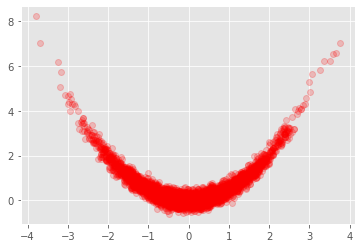

In [6]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2);

## Loading the Saved Model Parameters
Now, we demonstrate how to load the saved model parameters.

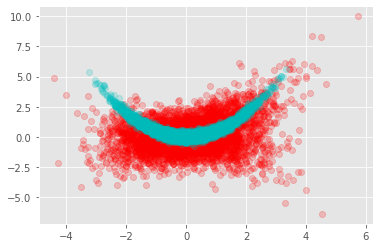

In [7]:
nvp_trained = NVP(load_model=model_file)
# First, show that it is untrained
forward_pass = nvp_trained(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:,0], forward_pass[:,1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

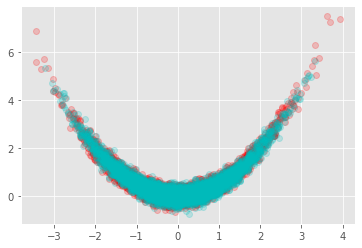

In [8]:
# Now, load the weights
nvp_trained.load_weights(checkpoint_path)
# It should be trained
forward_pass = nvp_trained(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:,0], forward_pass[:,1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)